### Alternate Preprocessing Using Tensorflow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.384447..1.6931235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.8098955..2.0014277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.6412234..1.847126].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.798675..2.0659776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5843945..1.5764].


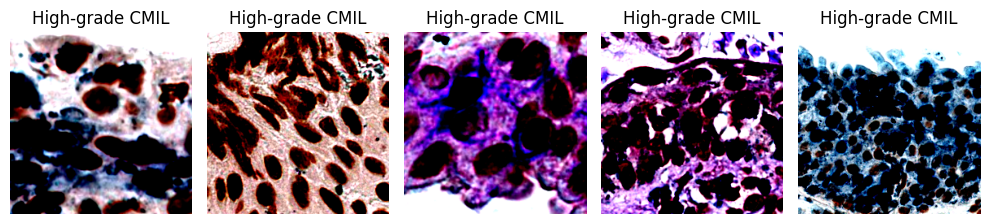

In [18]:
import os
import re
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

# === 1. Load labels CSV ===
labels = pd.read_csv('case_grade_match.csv')  # Change path if necessary

# === 2. Group patches by case number ===
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            case_patches.setdefault(case_num, []).append(os.path.join(patch_dir, filename))
    return case_patches

image_folder_path = 'Patches' # Change path if necessary
patches = group_patches(image_folder_path)

# === 3. Filter out class == 2 ===
case_nums = list(patches.keys())
dataset = labels.loc[[(int(x)-1) for x in case_nums]]  # Adjusting for 0-indexing?

filtered = dataset[dataset['Class'] != 2.0]
X = filtered['Case'].reset_index(drop=True)
y = filtered['Class'].reset_index(drop=True)

# === 4. Train-test-validation split ===
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X, y_train, test_size=0.2, stratify=y_train, random_state=40)

# === 5. Helper to create image-label pairs ===
def make_image_label_list(case_ids, patch_dict, labels_df):
    image_paths = []
    image_labels = []

    for case_num in case_ids:
        label_row = labels_df[labels_df['Case'] == case_num]
        if label_row.empty:
            continue
        label = label_row['Class'].values[0]
        label = 0 if label == 1 else 1  # Re-labeling logic: 1 -> 0 (benign), others -> 1 (high-grade CMIL)
        for path in patch_dict[int(case_num)]:
            image_paths.append(path)
            image_labels.append(label)
    
    return image_paths, image_labels

train_paths, train_labels = make_image_label_list(train_X, patches, labels)
val_paths, val_labels = make_image_label_list(val_X, patches, labels)
test_paths, test_labels = make_image_label_list(test_X, patches, labels)

# === 6. Function to reshape images and create a tf.data.Dataset ===
def load_dataset(image_paths, labels, batch_size=32, shuffle=True):
    def preprocess(image_path, label):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_png(img, channels=3) # Renders image into a 8-bit integer tensor and converts to RGB (3-channel)
        img = tf.image.resize(img, [256, 256]) # Resize to 256 x 256 array
        img = tf.image.central_crop(img, central_fraction=224/256) # Crop out center 224 x 224 pixels to finish resizing
        img = tf.cast(img, tf.float32) /255.0 # Cast each tensor to float type and normalize
        img = tf.image.per_image_standardization(img) # Standardize each image to have mean 0 and variance 1
        return img, label

    # Construct shuffled, pre-batched dataset for use in tf/keras models
    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = path_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = load_dataset(train_paths, train_labels)
val_ds = load_dataset(val_paths, val_labels)
test_ds = load_dataset(test_paths, test_labels, shuffle=False)

# === 7. Visualize a few samples ===
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    fig, axes = plt.subplots(ncols=5, figsize=(10, 4))
    for i in range(5):
        axes[i].imshow(images[i].numpy())
        axes[i].set_title("Benign" if labels[i].numpy() == 0 else "High-grade CMIL")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()